
# Define the species interaction network

We define the species interaction network:
* `positive_edges_dict`, a dictionary that specifies the positive interactions between species; and 
* `negative_edges_dict`, a dictionary that specifies the negative interactions between species.

In [34]:
# spp_list = ['s1','s2','s3','s4','s5']

# key is recipient of a positive effect
positive_edges_dict = {
's5': ['s4'],
's3': ['s2', 's4', 's5'],
}

# key is recipient of a negative effect
negative_edges_dict = {
's5': ['s5'],
's4': ['s4', 's5', 's3'],
's3': ['s3'],
's2': ['s2', 's1', 's3'],
's1': ['s1', 's2'],
}

We encode the network structure as a `networkx` digraph. The function `initialise_foodweb` stores the signs of the interactions in the edge data dictionary.

In [35]:
from qualmod import initialise_foodweb

web = initialise_foodweb(positive_edges_dict, negative_edges_dict)

# print edges
for edge in web.edges(data=True):
    print(edge)


('s5', 's5', {'color': 'red', 'sign': -1})
('s5', 's4', {'color': 'red', 'sign': -1})
('s5', 's3', {'color': 'green', 'sign': 1})
('s4', 's4', {'color': 'red', 'sign': -1})
('s4', 's5', {'color': 'green', 'sign': 1})
('s4', 's3', {'color': 'green', 'sign': 1})
('s3', 's4', {'color': 'red', 'sign': -1})
('s3', 's3', {'color': 'red', 'sign': -1})
('s3', 's2', {'color': 'red', 'sign': -1})
('s2', 's2', {'color': 'red', 'sign': -1})
('s2', 's1', {'color': 'red', 'sign': -1})
('s2', 's3', {'color': 'green', 'sign': 1})
('s1', 's2', {'color': 'red', 'sign': -1})
('s1', 's1', {'color': 'red', 'sign': -1})


The package `networkx` provides a quick way to plot the interaction network.

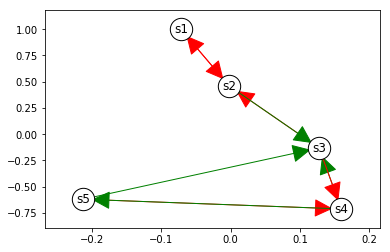

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

pos=nx.spring_layout(web)
nx.draw_networkx_labels(web, pos)
nx.draw_networkx_nodes(web, 
                       pos, 
                       node_color = 'white', 
                       edgecolors='black', 
                       node_size=500)

edge_colors = [ v[2]['color'] for v in web.edges(data=True) ]
nx.draw_networkx_edges(web, 
                       pos, 
                       edge_color=edge_colors, 
                       arrows=True, 
                       arrowsize=40);
plt.show()

The package `qualmod` also includes a function that uses `graphviz` to draw the interaction network. This is useful if we want to create a `.pdf` of the network to embed in a document, etc.

In [37]:
from qualmod import draw_foodweb
from IPython.display import IFrame
from IPython.display import Image
import os

# use draw_foodweb to create a graphviz dot file 
# defining the interaction network
draw_foodweb(web, f_name = 'web.dot')

# call graphviz externally to create a pdf of the 
# interaction network
os.system("dot -Tpdf web.dot > web.pdf")

# display the pdf of the interaction network here in Jupyter
# IFrame("web.pdf", width=500, height=600)

# call graphviz to create a png, display in 
# markdown cell
os.system("dot -Tpng web.dot > web.png")

0

![title](web.png)

`web.png`

The interaction network can also be converted into a qualitative community matrix, `Mq` below, using the function `qualitative_community_matrix`.

In [38]:
from qualmod import qualitative_community_matrix

(Mq, s2idx) = qualitative_community_matrix(web)
print(Mq)

[[-1. -1.  0.  0.  0.]
 [-1. -1. -1.  0.  0.]
 [ 0.  1. -1.  1.  1.]
 [ 0.  0. -1. -1. -1.]
 [ 0.  0.  0.  1. -1.]]


The function `qualitative_community_matrix` also returns `s2idx`, which is a handy bidirection dictionary that maps the name of the species to their index in the qualitative community matrix.

In [39]:
print(s2idx)
print(s2idx['s1'])
print(s2idx.inv[0])

bidict({'s1': 0, 's2': 1, 's3': 2, 's4': 3, 's5': 4})
0
s1


# Randomly sampling perturbation responses / parameter sweep

In the example in Fig. 2 of the paper, we are interested in the response of species `s3`, `s4`, and `s5` to a negative press-perturbation of species `s3`.

In [40]:
# which species is controlled 
# (i.e. perturbed e.g. by pest control program)
control_list = ['s3']

# the species we're interested in the responses of
monitored_list = ['s3','s4','s5']

In probabilistic Qualitative Modelling, the monitored species' response to the press-perturbation can be obtained using Monte Carlo simulation. The interaction-strength magnitudes in the community matrix are sampled from $a_{i,j} \sim \mathcal{U}(0,1)$, and the positive and negative responses are counted: `countResponses` below.

In the Boolean approach, random sampling can also be used to do a parameter-value sweep of the model behaviour. The objective is to obtain a set, `observedResponseCombinations`, that lists every species-response combination that is possible, regardless of what the interaction-strength magnitudes are. Here note that, although we again sample from a uniform distribution, the choice is of distribution is somewhat arbitrary. So long as we obtain good-enough coverage of the parameter space that we obtain every possible response combination, then any sampling distribution can be used.

In this example, we apply only one plausibility criterion: the community matrix must be stable.

The method uses the sensitivity matrix approach to obtain species responses (`Sq`).

In [41]:
import numpy as np

# size of the system, can also use sz = web.order()
sz = Mq.shape[0] 

# initialise collected responses with empty sets
observedResponseCombinations = set()

# initialise counts of positive responses with zeros
countResponses = np.array([0]*len(control_list)*len(monitored_list))

noSamples = 100
for n in range(noSamples): 
    
    # find a random community matrix that is stable
    maxEig = 1
    while maxEig > 0:
        
        M = np.multiply( np.random.random_sample((sz,sz)), Mq )
        maxEig = max(np.real(np.linalg.eigvals(M)))
        
    # find sensitivity matrix
    Sq = - np.linalg.inv(M)

    # Boolean approach:
    # ---
    
    #  find the signs of responses of each monitored species 
    #  to perturbations in each control species
    response = tuple(['neg' if Sq[s2idx[ms],s2idx[cs]]<0 else 'pos' 
                      for cs in control_list 
                      for ms in monitored_list ])
    
    
    #  add response to our collection of observed responses
    observedResponseCombinations.add(response)
    
    # Probabilistic approach:
    # ---
    
    #  add positive responses to count
    posResponses = np.array([ 0 if Sq[s2idx[ms],s2idx[cs]]<0 else 1 
                             for cs in control_list 
                             for ms in monitored_list ])
    countResponses += posResponses


The two types of intermediate results are shown below. For the probabilistic approach, we have a count of positive responses in each species:

In [42]:
countResponses

array([84, 16, 16])

For the Boolean approach, we have a list of species-response combinations:

In [43]:
observedResponseCombinations

{('neg', 'pos', 'pos'), ('pos', 'neg', 'neg')}

# Probabilistic approach

In the probabilistic approach, the proportions of responses giving positive or negative species response are interpreted probabilistically.

In this example, `probabilityResponses` gives stronger support for a positive response in species `s3`, and gives stronger support for a negative response in species `s4` and `s5`.

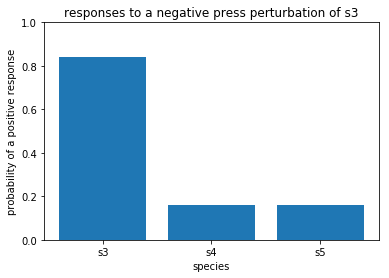

In [44]:
probabilityResponses = countResponses / noSamples

plt.title('responses to a negative press perturbation of s3')
plt.bar(range(len(monitored_list)), 
        probabilityResponses, 
        tick_label=monitored_list)
plt.ylim((0,1))
plt.ylabel('probability of a positive response')
plt.xlabel('species')
plt.show()

# Boolean approach

In the Boolean approach, the species response-combinations that the model predicts are interpreted using Boolean algebra.

Two species-response combinations were observed during the parameter-value sweep (shown as a table below). 

In [45]:
# the responses we'll be counting proportions on
desiredResponses = [ cs + '_' + ms 
                    for cs in control_list 
                    for ms in monitored_list]

# I have hardcoded the answer in here in case, by chance, 
# you miss a response combination in the random sampling above.
# For a real example, you will need to check that a large no. 
# of samples has been drawn since the last new response 
# combination was found.

if len(observedResponseCombinations) < 2:
    observedResponseCombinations = {
        ('neg', 'pos', 'pos'), 
        ('pos', 'neg', 'neg')
    }

# print the species response combinations that were observed 
# during the parameter sweep above in a table
header = ' | '.join(desiredResponses)
print(header)
print('-'*len(header))
for responseCombination in observedResponseCombinations:
    print(' ' + '  |  '.join(responseCombination))

s3_s3 | s3_s4 | s3_s5
---------------------
 pos  |  neg  |  neg
 neg  |  pos  |  pos


In order to use Boolean algebra, we need to convert the species responses into Boolean values. The responses have a natural dichotimisation i.e. a positive or a negative species response. Arbitrarily, we assign a positive species response as a `true`, and a negative species response as a `false`.

In [46]:
str4true = 'pos'; str4false = 'neg'

The simulations have returned the species-response combinations that are *possible* in the model, but the Boolean analysis is performed on the *impossible* combinations instead. If we assume that parameter sweep (above) was sufficient to obtain every possible combination, then the set of impossible combinations is simply the complement of the set of observed responses. In other words, the set of impossible combinations is the set of every response-combination that is combinatorially possible minus the set of responses that we observed.

There are a few different ways that we could obtain the complement, but one convenient way is to first observe that every response combination can be interpreted as a binary string, which can be interpreted as an integer. Then the complement corresponds to the list of integers that are missing from the set of integers that we observed.

First, we encode each observed response as a binary string, which is then converted into an integer:

In [47]:
observedInts = [
    int( ''.join(['1' if i in str4true else '0' 
                  for i in responseCombination]), 2 ) 
    for responseCombination in observedResponseCombinations
]
observedInts

[4, 3]

Then, the unobserved species responses correspond to the integers that are missing from `observedInts`:

In [48]:
# Start with set of all possible responses as integers ...
unobservedInts = set(range(2**len(desiredResponses)))
# ... and loop through the observed response combinations, 
# discarding those that were observed

for i in observedInts:
    unobservedInts.discard(i)
    
unobservedInts

{0, 1, 2, 5, 6, 7}

The function `getRespvarList2BoolvarList` converts the possible species-responses in the model into Boolean variables. It uses the [PyEDA package](https://pyeda.readthedocs.io/en/latest/).

In [49]:
from findpcu import getRespvarList2BoolvarList

# create our boolean variables and some useful dictionaries
x, x2s, r2idx = getRespvarList2BoolvarList(desiredResponses, 
                                           str4true, 
                                           str4false)

`x` is a list of the Boolean variables that have been created. For example, `s3_s4` is the variable that describes the response of species s4 to a negative perturbation of s3. `s3_s4` has the value `True` if s4 responds positively and `False` if s4 responds negatively.

In [50]:
x

[s3_s3, s3_s4, s3_s5]

`x2s` and `r2idx` are a bidirectional dictionaries that convert between a variable values and a corresponding string or index, respectively.

The next step is to use the function `intList2boolexpr` to turn the list of integers `unobservedInts`, corresponding to unobserved species responses, into a Boolean expression.

In [51]:
from findpcu import intList2boolexpr

# the boolean expression for our unobserved responses
unobservedBoolexpr = intList2boolexpr(unobservedInts, x)

The Boolean expression is returned in [disjunctive normal form](https://en.wikipedia.org/wiki/Disjunctive_normal_form), as a sum of products. Here the notation `~` is used to represent Not. For example, `~s3_s4` means "not a positive response in `s4` to a negative press-perturbation in `s3`", or in other words, "a negative response in `s4`".

In [52]:
print(unobservedBoolexpr)

Or(And(~s3_s3, ~s3_s4, ~s3_s5), And(~s3_s3, ~s3_s4, s3_s5), And(~s3_s3, s3_s4, ~s3_s5), And(s3_s3, ~s3_s4, s3_s5), And(s3_s3, s3_s4, ~s3_s5), And(s3_s3, s3_s4, s3_s5))


The list of unobserved species responses can also be easily converted into a truth table using the function `expr2truthtable` from PyEDA. This is the same table as given in Fig. 2a in the paper.

In [53]:
from pyeda.inter import expr2truthtable
expr2truthtable(unobservedBoolexpr)

s3_s5 s3_s4 s3_s3
    0     0     0 : 1
    0     0     1 : 0
    0     1     0 : 1
    0     1     1 : 1
    1     0     0 : 1
    1     0     1 : 1
    1     1     0 : 0
    1     1     1 : 1

In order to summarise the result, we perform a Boolean minimisation using the espresso algorithm.


In [54]:
from pyeda.inter import espresso_exprs

# Use espresso to minimise the unobservedBoolexpr
boolExprMin, = espresso_exprs(unobservedBoolexpr)

When we print out the resulting minimised Boolean expression, we see that it is shorter and simpler than the original (compare to `unobservedBoolexpr` above).

In [55]:
boolExprMin

Or(And(~s3_s4, s3_s5), And(s3_s3, s3_s4), And(~s3_s3, ~s3_s5))

Note however that `boolExprMin` is equivalent to the original expression. We can verify that by printing out its (full) truth table (using `expr2truthtable` again) and comparing it to the one above.

In [56]:
expr2truthtable(boolExprMin)

s3_s5 s3_s4 s3_s3
    0     0     0 : 1
    0     0     1 : 0
    0     1     0 : 1
    0     1     1 : 1
    1     0     0 : 1
    1     0     1 : 1
    1     1     0 : 0
    1     1     1 : 1

Each of the `And` terms in the minimised Boolean expression (`boolExprMin`) is called a PCU (short for the French "projection canonique ultime" meaning "ultimate canonical projection"), and Theuns (1994) discusses some of the theory behind them.

The function `boolexpr2RespvalList` converts each of the PCUs into a string, which can be useful if we wish to store the results in a file. This function also appends the strings (in our case `pos` and `neg`) that we designated above as `True` and `False`, to make the output quicker to read.

In [57]:
from findpcu import boolexpr2RespvalList

# returns the PCUs of the boolean expression as a list of strings
PCUList = boolexpr2RespvalList(boolExprMin, x2s)

PCUList

[['poss3_s3', 'poss3_s4'], ['negs3_s5', 'negs3_s3'], ['poss3_s5', 'negs3_s4']]

Each PCU can be used to derive a set of logical implications, and these implications can be chained together to create a logical implication network.

All that is needed to ensure that the logical implication network describes the full behaviour of the model is to ensure that at least one implication is derived from each PCU. However, for small networks, it may be preferable to include more than one implication. The function `draw_implication_network` draws the network in such a way that every implication with 1 antecedent is included.

In [58]:
from findpcu import draw_implication_network

draw_implication_network(PCUList)

# display the pdf of the interaction network here in Jupyter
# IFrame("implication_network.pdf", width=500, height=500)

# call graphviz to create a png, display in markdown cell
os.system("dot -Tpng implication_network.dot > implication_network.png")

implication_network.pdf has been created


0

![title](implication_network.png)

`implication_network.png`

We can see that each PCU is represented twice in the implication network above. For example, `['poss3_s3', 'poss3_s4']` translates to saying that the following combination of species responses is impossible in the model: positive s3 and positive s4. Therefore a positive response in s3 implies a negative response in s4 (seen in left-hand subnetwork), and a positive response in s4 implies a negative response in s3 (seen in right-hand subnetwork).

Another function is available, `draw_implication_network2`, to draw the implication network with only one implication per PCU. We can specify which species responses we wish to see as the antecedents. The example below also shows some of its other options.


In [59]:
from findpcu import draw_implication_network2

# make a positive response of s3 always an antecedent
alwaysAnteList = ['poss3_s3', 'negs3_s5', 'negs3_s4'] 

niceNames = { # names of each species
    's3': 'species 3',
    's4': 'species 4',
    's5': 'species 5',
}

fName = 'implication_network_2' # name of the .dot file and .pdf file

controlSymbol = '&#9785;' # html code for a sad face

draw_implication_network2(PCUList, 
                          alwaysAnteList, 
                          fName, 
                          niceNames, 
                          controlSymbol)

os.system("dot -Tpng implication_network_2.dot > implication_network_2.png")

implication_network_2.pdf has been created


0

![title](implication_network_2.png)

`implication_network_2.png`